# A PWM Generator design with OpenLane

```
Ayan Biswas, November 2022
SPDX-License-Identifier: Apache-2.0
```

## Category 1 submission


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Ayan Biswas (Lead) <br /> Email ID: ayanbiswas184@gmail.com|Jadavpur University|Yes|No|


A PWM generator is a digital circuit that produces a pulse-width modulated output signal. The duty cycle of the output signal is controlled by a digital input signal. Here in this design a new age circuit generator framework [OpenLane](openlane.readthedocs.io) is used to generate the circuit layout from it's verilog code

**_Index Terms:_** Circuit generator, Pulse-width-modulation generator, openlane

Citation: 

1. Shalan, M., & Edwards, T. (2020). Building OpenLANE. In Proceedings of the 39th International Conference on Computer-Aided Design. ICCAD ’20: IEEE/ACM International Conference on Computer-Aided Design. ACM. https://doi.org/10.1145/3400302.3415735

2. Srivastava, R., Chauhan, Y. K., & Kumar, B. (2016). Generation of PWM using verilog In FPGA. In 2016 International Conference on Electrical, Electronics, and Optimization Techniques (ICEEOT). 2016 International Conference on Electrical, Electronics, and Optimization Techniques (ICEEOT). IEEE. https://doi.org/10.1109/iceeot.2016.7755586

## PWM Generator

A PWM generator circuit is a device that produces a pulse-width modulated signal. This signal can be used to control the duty cycle of a switch-mode power supply or to drive a motor with variable speed. The circuit typically consists of a sawtooth wave generator and a comparator. The sawtooth wave generator produces a ramp voltage that is fed to the non-inverting input of the comparator. The output of the comparator is a square wave with a duty cycle that is proportional to the ramp voltage.

![image1.png](image_ckt.png)

#### This is how PWM works:

A higher modulation signal will result in an output that is at a high level for a greater fraction of the PWM period. This is because the negative input of the operational amplifier is used for the carrier, while the positive input is used for the modulation signal.

Here a PWM circuit is first modelled using verilog and then the entire circuitry was produced using the circuit generator framework [OpenLane](openlane.readthedocs.io)

### Dependencies and Software Installation

In [1]:
# Installing the dependencies
openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --quiet --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version}
!CI=0 bin/micromamba install --quiet --yes --prefix $CONDA_PREFIX \
                     --channel conda-forge \
                     gdstk

env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env
  Package                             Version  Build                 Channel                 Size
───────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
───────────────────────────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                         0

### Verilog Code for PWM generator

In [15]:
%%writefile PWM_Generator_Verilog.v
// Verilog code for PWM Generator with variable Duty Cycle
// In this design two debounced buttons are used to control the duty cycle (step size: 10%)

module PWM_Generator_Verilog
 (
 clk, // 100MHz clock input 
 increase_duty, // input to increase 10% duty cycle 
 decrease_duty, // input to decrease 10% duty cycle 
 PWM_OUT // 10MHz PWM output signal 
    );
  
 input clk;
 input increase_duty;
 input decrease_duty;
 output PWM_OUT;
 wire slow_clk_enable; // slow clock enable signal for debouncing FFs
 reg[27:0] counter_debounce=0;// counter for creating slow clock enable signals 
 wire tmp1,tmp2,duty_inc;// temporary flip-flop signals for debouncing the increasing button
 wire tmp3,tmp4,duty_dec;// temporary flip-flop signals for debouncing the decreasing button
 reg[3:0] counter_PWM=0;// counter for creating 10Mhz PWM signal
 reg[3:0] DUTY_CYCLE=5; // initial duty cycle is 50%
  // Debouncing 2 buttons for inc/dec duty cycle 
  // Firstly generate slow clock enable for debouncing flip-flop (4Hz)
 
 always @(posedge clk)
 begin
   counter_debounce <= counter_debounce + 1;
   //if(counter_debounce>=25000000) then  
   // for running on FPGA -- comment when running simulation
   if(counter_debounce>=1) 
   // for running simulation -- comment when running on FPGA
    counter_debounce <= 0;
 end
 
 // assign slow_clk_enable = counter_debounce == 25000000 ?1:0;
 // for running on FPGA -- comment when running simulation 
 assign slow_clk_enable = counter_debounce == 1 ?1:0;
 // for running simulation -- comment when running on FPGA
 // debouncing FFs for increasing button
 DFF_PWM PWM_DFF1(clk,slow_clk_enable,increase_duty,tmp1);
 DFF_PWM PWM_DFF2(clk,slow_clk_enable,tmp1, tmp2); 
 assign duty_inc =  tmp1 & (~ tmp2) & slow_clk_enable;
 // debouncing FFs for decreasing button
 DFF_PWM PWM_DFF3(clk,slow_clk_enable,decrease_duty, tmp3);
 DFF_PWM PWM_DFF4(clk,slow_clk_enable,tmp3, tmp4); 
 assign duty_dec =  tmp3 & (~ tmp4) & slow_clk_enable;
 // vary the duty cycle using the debounced buttons above
 always @(posedge clk)
 begin
   if(duty_inc==1 && DUTY_CYCLE <= 9) 
    DUTY_CYCLE <= DUTY_CYCLE + 1;// increase duty cycle by 10%
   else if(duty_dec==1 && DUTY_CYCLE>=1) 
    DUTY_CYCLE <= DUTY_CYCLE - 1;//decrease duty cycle by 10%
 end 
// Create 10MHz PWM signal with variable duty cycle controlled by 2 buttons 
 always @(posedge clk)
 begin
   counter_PWM <= counter_PWM + 1;
   if(counter_PWM>=9) 
    counter_PWM <= 0;
 end
 assign PWM_OUT = counter_PWM < DUTY_CYCLE ? 1:0;
endmodule
// Debouncing DFFs for push buttons on FPGA
module DFF_PWM(clk,en,D,Q);
input clk,en,D;
output reg Q;
always @(posedge clk)
begin 
 if(en==1) // slow clock enable signal 
  Q <= D;
end 
endmodule

Writing PWM_Generator_Verilog.v


### Configuration file for testing the design

In [32]:
%%writefile config.json
{
    "DESIGN_NAME": "PWM_Generator_Verilog",
    "VERILOG_FILES": "dir::PWM_Generator_Verilog.v",
    "CLOCK_PORT": null
}

Overwriting config.json


In [33]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f0668447616c071f145d3d3fa1dfde9762b62b7b, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

### Results

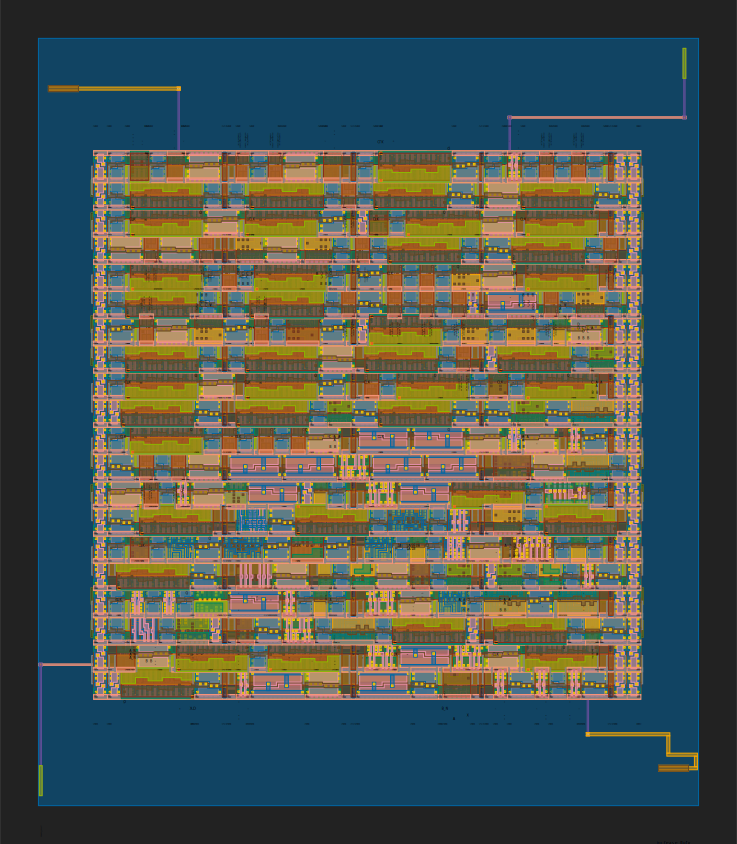

In [28]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('pwmgenerator.svg')
IPython.display.SVG('pwmgenerator.svg')

### Circuit Specifications

In [29]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

,0
design,/content
design_name,PWM_Generator_Verilog
config,RUN_2022.11.20_07.00.47
flow_status,flow completed
total_runtime,0h1m21s0ms
routed_runtime,0h1m6s0ms
(Cell/mm^2)/Core_Util,52071.576702
DIEAREA_mm^2,0.00507
CellPer_mm^2,26035.788351
OpenDP_Util,54.56
